# Create Transit Rich Areas Dataset

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

In [73]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import requests
import getpass
from pyproj import CRS
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

### Read in password from file

**Important:** Do not put passwords or sensitive information into this notebook. Read in from seperate file or add to DataViz creds file. 

In [17]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [18]:
pass_txt = '../../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

In [19]:
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

## Pull Existing Transit Stops 2020 Data from Portal and Buffer

In [20]:
#Pull data from arcgis portal
transit_stops_exist = pull_geodata_from_argis('3faf8401623b48ae8d70f7a71d7365c9',client=gis)

In [21]:
transit_stops_exist.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
#project to NAD83 UTMZ10
transit_stops_exist_nad83 = transit_stops_exist.to_crs('EPSG:26910')

In [23]:
transit_stops_exist_nad83.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 126°W to 120°W and NAD83 by country
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [24]:
transit_stops_exist_nad83.head(5)

,agency_id,agency_nm,hdwy_15min,hdwy_30min,hdwy_class,loc_type,major_stop,objectid,route_ty_t,route_type,stop_code,stop_desc,stop_id,stop_name,geom
0,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,1,Rail,2.0,12TH,,12TH,12th St. Oakland City Center,POINT (564135.244 4184293.205)
1,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,2,Rail,2.0,16TH,,16TH,16th St. Mission,POINT (551112.002 4179906.983)
2,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,3,Rail,2.0,19TH,,19TH,19th St. Oakland,POINT (564382.160 4184803.318)
3,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,4,Rail,2.0,24TH,,24TH,24th St. Mission,POINT (551257.209 4178510.984)
4,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,5,Rail,2.0,ANTC,,ANTC,Antioch,POINT (607084.546 4206005.178)


In [25]:
transit_stops_exist_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22300 entries, 0 to 22299
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_id   22278 non-null  object  
 1   agency_nm   22278 non-null  object  
 2   hdwy_15min  22300 non-null  int64   
 3   hdwy_30min  22300 non-null  int64   
 4   hdwy_class  22300 non-null  object  
 5   loc_type    22300 non-null  object  
 6   major_stop  22300 non-null  int64   
 7   objectid    22300 non-null  int64   
 8   route_ty_t  22278 non-null  object  
 9   route_type  22278 non-null  float64 
 10  stop_code   22300 non-null  object  
 11  stop_desc   22300 non-null  object  
 12  stop_id     22300 non-null  object  
 13  stop_name   22300 non-null  object  
 14  geom        22300 non-null  geometry
dtypes: float64(1), geometry(1), int64(4), object(9)
memory usage: 2.6+ MB


In [26]:
transit_stops_exist_nad83['route_ty_t'].unique()

array(['Rail', 'Bus', 'Tram, Streetcar, Light Rail', 'Cable Tram', None,
       'Ferry'], dtype=object)

In [27]:
#Filter stops to include stops w/ types as well as stops with routes headways of 15 mins or less
transit_stops_exist_nad83 = transit_stops_exist_nad83[(transit_stops_exist_nad83['hdwy_15min'] == 1) & 
                                                  (transit_stops_exist_nad83['route_ty_t'].isin(['Rail', 
                                                                                              'Bus', 
                                                                                              'Tram, Streetcar, Light Rail',
                                                                                              'Cable Tram',
                                                                                              'Ferry']))].copy()

In [28]:
transit_stops_exist_nad83.shape

(6414, 15)

In [29]:
#Buffer existing transit stops by 1/2 mile
buffer_distance = .5 * 1609.344
transit_stops_exist_nad83['geom'] = transit_stops_exist_nad83.buffer(buffer_distance)

In [30]:
transit_stops_exist_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6414 entries, 0 to 21496
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_id   6414 non-null   object  
 1   agency_nm   6414 non-null   object  
 2   hdwy_15min  6414 non-null   int64   
 3   hdwy_30min  6414 non-null   int64   
 4   hdwy_class  6414 non-null   object  
 5   loc_type    6414 non-null   object  
 6   major_stop  6414 non-null   int64   
 7   objectid    6414 non-null   int64   
 8   route_ty_t  6414 non-null   object  
 9   route_type  6414 non-null   float64 
 10  stop_code   6414 non-null   object  
 11  stop_desc   6414 non-null   object  
 12  stop_id     6414 non-null   object  
 13  stop_name   6414 non-null   object  
 14  geom        6414 non-null   geometry
dtypes: float64(1), geometry(1), int64(4), object(9)
memory usage: 801.8+ KB


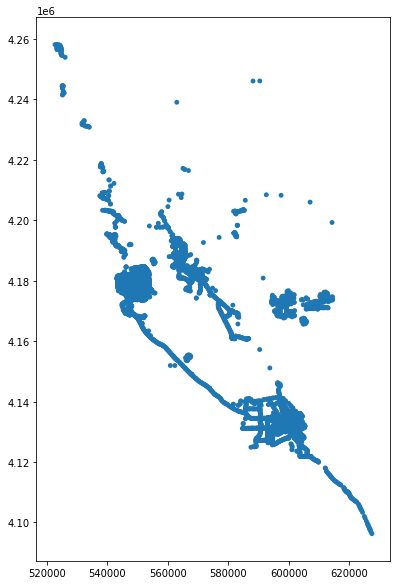

In [31]:
transit_stops_exist_nad83.plot(figsize=(10,10));

## Pull Planned and Potential Stops from Portal and Buffer

In [32]:
#Pull data from arcgis portal
transit_stops_plan = pull_geodata_from_argis('18a6239819b048fab9c87bb4d7649560',client=gis)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [33]:
#Project to NAD83 UTMZ10
transit_stops_plan_nad83 = transit_stops_plan.to_crs('EPSG:26910')

In [34]:
transit_stops_plan_nad83.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 126°W to 120°W and NAD83 by country
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
transit_stops_plan_nad83.head(5)

,objectid,county,jurisdictn,agency_nm,stop_name,route_ty_t,ppa_id,ppa_name,committd,status,exp_open,geom
0,1,CA013,Brentwood,TBD,Brentwood,Bus,2202,Bus Rapid Transit to Brentwood (formerly BART ...,No,Final Blueprint,2021-2035,POINT (610284.281 4201385.715)
1,2,CA097,Healdsburg,Sonoma-Marin Area Rail Transit,Healdsburg,Rail,2304,SMART to Cloverdale,No,Not Included,Not Included,POINT (511636.968 4273185.826)
2,3,CA097,Cloverdale,Sonoma-Marin Area Rail Transit,Cloverdale,Rail,2304,SMART to Cloverdale,No,Not Included,Not Included,POINT (498953.967 4294420.424)
3,4,CA085,San Jose,Santa Clara Valley Transportation Authority,San Jose Airport,"Tram, Streetcar, Light Rail",2402,San Jose Airport People Mover,No,Not Included,Not Included,POINT (595075.482 4136054.501)
4,5,CA085,Cupertino,Bay Area Rapid Transit,De Anza College,"Tram, Streetcar, Light Rail",2206,Stevens Creek Line (formerly BART to Cupertino),No,Final Blueprint,2036-2050,POINT (585044.618 4131116.515)


In [36]:
transit_stops_plan_nad83['status'].unique()

array(['Final Blueprint', 'Not Included', 'Draft Blueprint',
       'Under Construction'], dtype=object)

In [37]:
#filter for stops in the Final Blueprint or Under Construction
transit_stops_plan_nad83 = transit_stops_plan_nad83[transit_stops_plan_nad83['status'].isin(['Final Blueprint',
                                                                                             'Under Construction'])].copy()

In [38]:
transit_stops_plan_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18 entries, 0 to 91
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    18 non-null     int64   
 1   county      18 non-null     object  
 2   jurisdictn  18 non-null     object  
 3   agency_nm   18 non-null     object  
 4   stop_name   18 non-null     object  
 5   route_ty_t  17 non-null     object  
 6   ppa_id      18 non-null     int64   
 7   ppa_name    18 non-null     object  
 8   committd    18 non-null     object  
 9   status      18 non-null     object  
 10  exp_open    18 non-null     object  
 11  geom        18 non-null     geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 1.8+ KB


In [39]:
#Buffer planned and potential stops by 1/2 mile
buffer_distance = .5 * 1609.344
transit_stops_plan_nad83['geom'] = transit_stops_plan_nad83.buffer(buffer_distance)

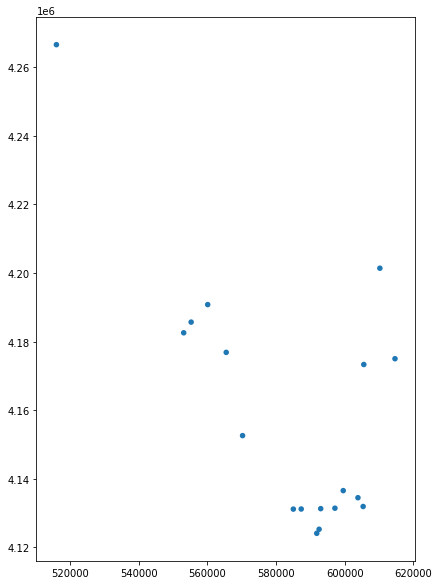

In [40]:
transit_stops_plan_nad83.plot(figsize=(10,10));

## Pull PBA2050 Transit Project Lines

In [41]:
#pull from portal
transit_lines_plan = pull_geodata_from_argis('c977b5c75587445fb25ba7beea5d2348',client=gis)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [42]:
transit_lines_plan.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
transit_lines_plan.head(5)

,objectid,proj_name,proj_id,date,edited_by,type,proj_desc,trans_type,final_bp,SHAPE__Length,geom
0,1,Crossing Concept #1,b569ce86-c447-11e9-99c0-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 1,None,0,0.226824,"MULTILINESTRING ((-122.09466 37.64571, -122.09..."
1,2,Crossing Concept #2,b56cf8fa-c447-11e9-a898-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 2,None,0,0.278014,"MULTILINESTRING ((-122.40540 37.63570, -122.40..."
2,3,Crossing Concept #3,b56cfc46-c447-11e9-b877-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 3,None,0,0.303308,"MULTILINESTRING ((-122.46832 37.70637, -122.46..."
3,4,Crossing Concept #4,b56cfc9e-c447-11e9-a5e3-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 4,None,0,0.326996,"MULTILINESTRING ((-122.46859 37.70637, -122.46..."
4,5,Crossing Concept #5,b56cfcf8-c447-11e9-8e22-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 5,None,0,0.139503,"MULTILINESTRING ((-122.39553 37.78951, -122.39..."


In [44]:
#project to UTMZ10
transit_lines_plan_nad83 = transit_lines_plan.to_crs('EPSG:26910')

In [45]:
transit_lines_plan_nad83['trans_type'].unique()

array([None, 'Local Bus', 'Group Rapid Transit', 'Commuter Rail',
       'Local Rapid Bus', 'Regional Express Bus', 'Bus Rapid Transit',
       'Light Rail', 'Ferry', 'Bicycle', 'Road',
       'Automated Vehicle Shuttle', 'Maglev Rail'], dtype=object)

In [46]:
#filter for BRT projects
transit_lines_plan_nad83 = transit_lines_plan_nad83[(transit_lines_plan_nad83['final_bp'] == 1) &
                                                    (transit_lines_plan_nad83['trans_type'] == 'Bus Rapid Transit')].copy()

In [47]:
transit_lines_plan_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


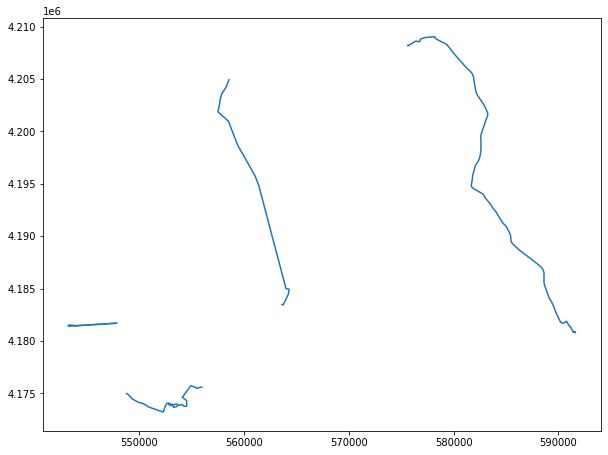

In [48]:
transit_lines_plan_nad83.plot(figsize=(10,10));

In [49]:
#Buffer BRT transit lines by 1/2 mile
buffer_distance = .5 * 1609.344
transit_lines_plan_nad83['geom'] = transit_lines_plan_nad83.buffer(buffer_distance)

In [50]:
transit_lines_plan_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


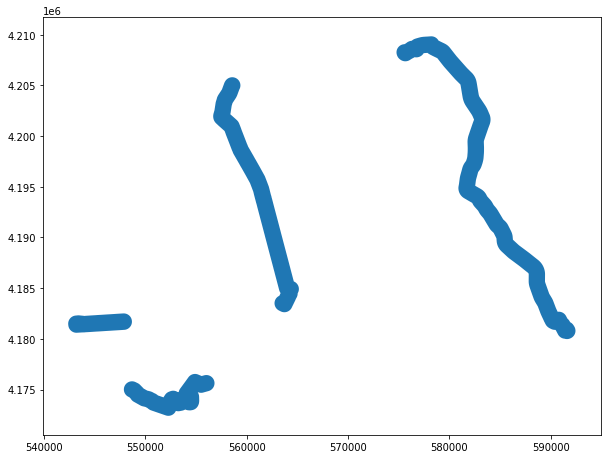

In [51]:
transit_lines_plan_nad83.plot(figsize=(10,10));

## Append Point Datasets

In [52]:
stops_append = transit_stops_exist_nad83[['agency_nm',
                                          'route_ty_t',
                                          'stop_name',
                                          'geom']].append(transit_stops_plan_nad83[['agency_nm',
                                                                                    'route_ty_t',
                                                                                    'stop_name',
                                                                                    'geom']])

In [53]:
stops_append.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6432 entries, 0 to 91
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_nm   6432 non-null   object  
 1   route_ty_t  6431 non-null   object  
 2   stop_name   6432 non-null   object  
 3   geom        6432 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 251.2+ KB


## Append Point and Line Datasets

In [54]:
transit_lines_plan_nad83.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


In [55]:
transit_lines_plan_nad83.rename(columns={'trans_type':'route_ty_t'},inplace=True)

In [56]:
stops_lines_append = stops_append.append(transit_lines_plan_nad83[['proj_name',
                                                                   'final_bp',
                                                                   'route_ty_t',
                                                                   'geom']])

In [57]:
stops_lines_append.head(5)

,agency_nm,route_ty_t,stop_name,geom,proj_name,final_bp
0,Bay Area Rapid Transit,Rail,12th St. Oakland City Center,"POLYGON ((564939.916 4184293.205, 564936.041 4...",NaN,NaN
1,Bay Area Rapid Transit,Rail,16th St. Mission,"POLYGON ((551916.674 4179906.983, 551912.799 4...",NaN,NaN
2,Bay Area Rapid Transit,Rail,19th St. Oakland,"POLYGON ((565186.832 4184803.318, 565182.957 4...",NaN,NaN
3,Bay Area Rapid Transit,Rail,24th St. Mission,"POLYGON ((552061.881 4178510.984, 552058.007 4...",NaN,NaN
4,Bay Area Rapid Transit,Rail,Antioch,"POLYGON ((607889.218 4206005.178, 607885.343 4...",NaN,NaN


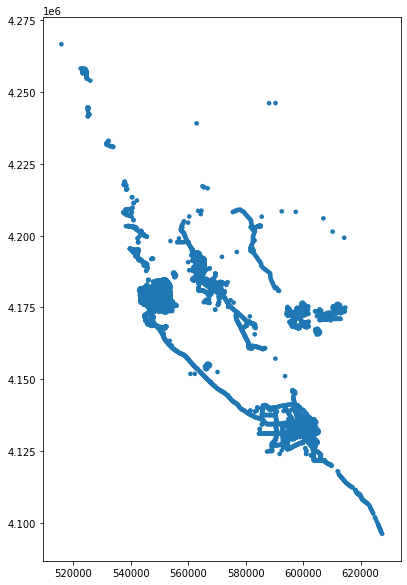

In [58]:
stops_lines_append.plot(figsize=(10,10));

In [ ]:
stops_lines_append.to_crs()

In [59]:
#Unproject 
stops_lines_append_wgs84 = stops_lines_append.to_crs('EPSG:4326')

In [60]:
stops_lines_append_wgs84.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
stops_lines_append_wgs84['diss'] = 1
stops_lines_append_wgs84_diss = stops_lines_append_wgs84[['diss','geom']].dissolve(by='diss',as_index=False)

In [62]:
stops_lines_append_wgs84_diss['f_name'] = 'Transit Rich Areas'

In [63]:
#Output to geojson for inspection
stops_lines_append_wgs84_diss.to_file('../transit_rich_areas.geojson',driver='GeoJSON')

## Convert to ESRI spatial data frame

In [64]:
stops_lines_append_wgs84_sdf = pd.DataFrame.spatial.from_geodataframe(stops_lines_append_wgs84_diss,
                                                                      column_name='geom')

In [65]:
stops_lines_append_wgs84_sdf.shape

(1, 3)

In [66]:
stops_lines_append_wgs84_sdf.spatial.sr

{'wkid': 4326}

In [67]:
stops_lines_append_wgs84_sdf.head(5)

,diss,f_name,geom
0,1,Transit Rich Areas,"{""rings"": [[[-121.55756870995748, 37.003790447..."


In [68]:
title = 'Transit Rich Areas 2020 v2'
folder = 'Plan Bay Area 2050'
stops_lines_append_wgs84_sdf.spatial.to_featurelayer(title,folder=folder)

<Item title:"Transit Rich Areas 2020 v2" type:Feature Layer Collection owner:jcroff>

In [74]:
tran = pull_geodata_from_argis('e778def232f1478eafe2bb404fb8c7cd',client=gis)

CRSError: Invalid projection: +init=epsg:102100 +type=crs: (Internal Proj Error: proj_create: crs not found)

In [75]:
tra_portal = gis.content.get('e778def232f1478eafe2bb404fb8c7cd')

In [76]:
tra_portal

<Item title:"Transit Rich Areas 2020 v2" type:Feature Layer Collection owner:jcroff>

In [77]:
tra_portal.layers

[<FeatureLayer url:"https://arcgis.ad.mtc.ca.gov/server/rest/services/Hosted/a3f462/FeatureServer/0">]

In [78]:
tra_portal.layers[0].properties

{
  "currentVersion": 10.8,
  "cimVersion": "2.5.0",
  "id": 0,
  "name": "se15fd",
  "type": "Feature Layer",
  "parentLayer": null,
  "defaultVisibility": true,
  "minScale": 0,
  "maxScale": 577790,
  "canScaleSymbols": false,
  "geometryType": "esriGeometryPolygon",
  "description": "",
  "copyrightText": "",
  "editFieldsInfo": null,
  "syncCanReturnChanges": true,
  "relationships": [],
  "isDataVersioned": false,
  "isDataArchived": false,
  "isDataBranchVersioned": false,
  "isCoGoEnabled": false,
  "supportsRollbackOnFailureParameter": true,
  "supportsStatistics": true,
  "supportsAdvancedQueries": true,
  "supportsValidateSQL": true,
  "supportsCoordinatesQuantization": true,
  "supportsCalculate": true,
  "supportsASyncCalculate": true,
  "advancedQueryCapabilities": {
    "supportsReturningQueryExtent": true,
    "supportsStatistics": true,
    "supportsDistinct": true,
    "supportsPagination": true,
    "supportsOrderBy": true,
    "supportsQueryWithDistance": true,
    